<a href="https://colab.research.google.com/github/hjesse92/Tensorflow-Practice/blob/main/Deeplearning_ai_NLP_Week4_Exercise_Shakespeare_Question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
### YOUR CODE HERE
# Figure out how to import regularizers
###
import tensorflow.keras.utils as ku 
import numpy as np 

In [2]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2020-11-07 02:41:54--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.15.112, 172.217.2.112, 172.217.164.144, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.15.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2020-11-07 02:41:54 (75.0 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [7]:
max_sequence_len

11

In [19]:
model = Sequential()
model.add(Embedding(total_words, 500, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.1))
model.add(LSTM(100))
model.add(Dense(256, activation='relu', kernel_regularizer='l2'))
model.add(Dense(total_words, activation='softmax'))
# Pick an optimizer
es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['acc'])
print(model.summary())


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 10, 500)           1605500   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 10, 200)           480800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 200)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dense_8 (Dense)              (None, 256)               25856     
_________________________________________________________________
dense_9 (Dense)              (None, 3211)              825227    
Total params: 3,057,783
Trainable params: 3,057,783
Non-trainable params: 0
____________________________________________

In [20]:
 history = model.fit(predictors, label, validation_split=0.1, epochs=100, callbacks=[es], verbose=1)

Epoch 1/100
435/435 [==============================] - 10s 24ms/step - loss: 7.0404 - acc: 0.0223 - val_loss: 6.7645 - val_acc: 0.0123
Epoch 2/100
435/435 [==============================] - 10s 22ms/step - loss: 6.4901 - acc: 0.0231 - val_loss: 6.9306 - val_acc: 0.0220
Epoch 3/100
435/435 [==============================] - 9s 22ms/step - loss: 6.3871 - acc: 0.0264 - val_loss: 7.0396 - val_acc: 0.0200
Epoch 4/100
435/435 [==============================] - 9s 21ms/step - loss: 6.2769 - acc: 0.0333 - val_loss: 7.1462 - val_acc: 0.0246
Epoch 5/100
435/435 [==============================] - 9s 21ms/step - loss: 6.1681 - acc: 0.0367 - val_loss: 7.1627 - val_acc: 0.0233
Epoch 6/100
435/435 [==============================] - 9s 22ms/step - loss: 6.0748 - acc: 0.0390 - val_loss: 7.4150 - val_acc: 0.0394
Epoch 7/100
435/435 [==============================] - 9s 21ms/step - loss: 5.9926 - acc: 0.0419 - val_loss: 7.4632 - val_acc: 0.0252
Epoch 8/100
435/435 [==============================] - 9s 21

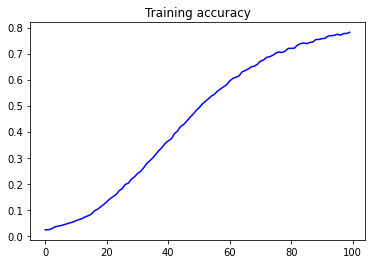

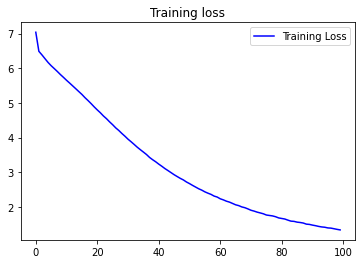

In [21]:
import matplotlib.pyplot as plt
acc = history.history['acc']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [35]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list, verbose=0))
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope to me vile hate ' exceed fled fled sought ranged dun dun fire is growth to take of eye of one spent light grow use they large deem'd deceive deceive show me mine eyes she you no end see well suppress'd lend changing power his form had well sheds decay go place that i could not bright bright deeds of thee knowing me life belongs to rest wind smells fire doth speak of you pattern of all vile kind doth invent miss'd deceive ride sight doth kept fill their dearest ill night to die be stand gain from me doth


In [36]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [37]:
pp.pprint(seed_text)

("Help me Obi Wan Kenobi, you're my only hope to me vile hate ' exceed fled "
 'fled sought ranged dun dun fire is growth to take of eye of one spent light '
 "grow use they large deem'd deceive deceive show me mine eyes she you no end "
 "see well suppress'd lend changing power his form had well sheds decay go "
 'place that i could not bright bright deeds of thee knowing me life belongs '
 'to rest wind smells fire doth speak of you pattern of all vile kind doth '
 "invent miss'd deceive ride sight doth kept fill their dearest ill night to "
 'die be stand gain from me doth')
